Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Iter: 0
D loss: 1.31
G_loss: 2.368



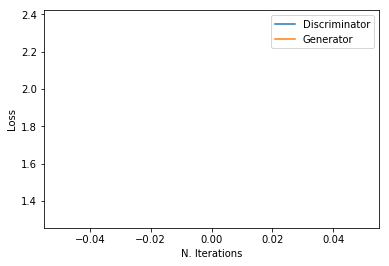

Iter: 1000
D loss: 0.09165
G_loss: 5.589

Iter: 2000
D loss: 0.06039
G_loss: 4.275

Iter: 3000
D loss: 0.1202
G_loss: 5.052

Iter: 4000
D loss: 0.1293
G_loss: 4.427

Iter: 5000
D loss: 0.7005
G_loss: 5.083

Iter: 6000
D loss: 0.3387
G_loss: 3.049

Iter: 7000
D loss: 0.2455
G_loss: 4.051

Iter: 8000
D loss: 0.7009
G_loss: 3.823

Iter: 9000
D loss: 0.9066
G_loss: 2.285

Iter: 10000
D loss: 1.061
G_loss: 1.427



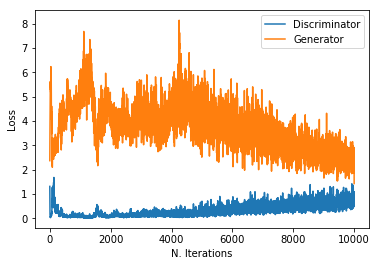

Iter: 11000
D loss: 0.5582
G_loss: 2.956

Iter: 12000
D loss: 0.8544
G_loss: 2.607

Iter: 13000
D loss: 0.8631
G_loss: 2.209

Iter: 14000
D loss: 0.6755
G_loss: 2.362

Iter: 15000
D loss: 0.9216
G_loss: 1.647

Iter: 16000
D loss: 0.8894
G_loss: 1.607

Iter: 17000
D loss: 0.9323
G_loss: 1.851

Iter: 18000
D loss: 0.7211
G_loss: 1.875

Iter: 19000
D loss: 0.9354
G_loss: 1.65

Iter: 20000
D loss: 1.047
G_loss: 1.293



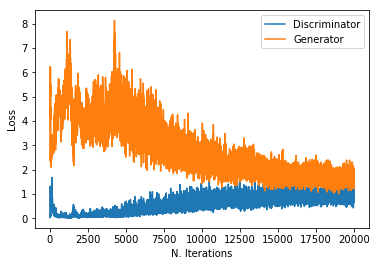

Iter: 21000
D loss: 0.9384
G_loss: 1.598

Iter: 22000
D loss: 1.01
G_loss: 1.514

Iter: 23000
D loss: 0.9766
G_loss: 1.658

Iter: 24000
D loss: 1.086
G_loss: 1.901

Iter: 25000
D loss: 0.7626
G_loss: 1.423

Iter: 26000
D loss: 0.8865
G_loss: 1.498

Iter: 27000
D loss: 1.031
G_loss: 1.331

Iter: 28000
D loss: 1.005
G_loss: 1.375

Iter: 29000
D loss: 0.8217
G_loss: 1.623

Iter: 30000
D loss: 0.8737
G_loss: 1.482



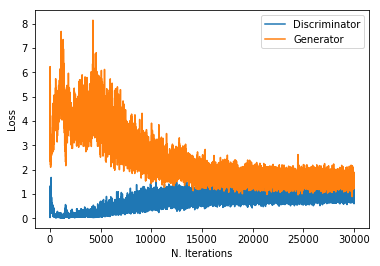

Iter: 31000
D loss: 0.8774
G_loss: 1.285

Iter: 32000
D loss: 0.8084
G_loss: 1.579

Iter: 33000
D loss: 1.194
G_loss: 1.388

Iter: 34000
D loss: 0.8229
G_loss: 1.654

Iter: 35000
D loss: 0.854
G_loss: 1.699

Iter: 36000
D loss: 0.9813
G_loss: 1.615

Iter: 37000
D loss: 0.8293
G_loss: 1.595

Iter: 38000
D loss: 1.16
G_loss: 1.359

Iter: 39000
D loss: 0.7895
G_loss: 1.812

Iter: 40000
D loss: 1.11
G_loss: 1.314



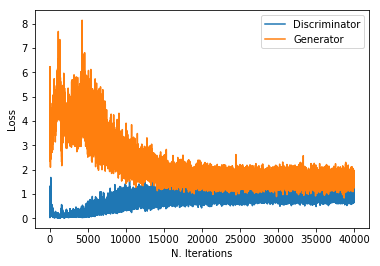

Iter: 41000
D loss: 0.7911
G_loss: 1.627

Iter: 42000
D loss: 1.097
G_loss: 1.486



KeyboardInterrupt: 

In [6]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

%matplotlib inline

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 16])
c = tf.placeholder(tf.float32, shape=[None, 10])

G_W1 = tf.Variable(xavier_init([26, 256]))
G_b1 = tf.Variable(tf.zeros(shape=[256]))

G_W2 = tf.Variable(xavier_init([256, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


Q_W1 = tf.Variable(xavier_init([784, 128]))
Q_b1 = tf.Variable(tf.zeros(shape=[128]))

Q_W2 = tf.Variable(xavier_init([128, 10]))
Q_b2 = tf.Variable(tf.zeros(shape=[10]))

theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def sample_c(m):
    return np.random.multinomial(1, 10*[0.1], size=m)


def generator(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob


def Q(x):
    Q_h1 = tf.nn.relu(tf.matmul(x, Q_W1) + Q_b1)
    Q_prob = tf.nn.softmax(tf.matmul(Q_h1, Q_W2) + Q_b2)

    return Q_prob


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


G_sample = generator(Z, c)
D_real = discriminator(X)
D_fake = discriminator(G_sample)
Q_c_given_x = Q(G_sample)

D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8))

cross_ent = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c_given_x + 1e-8) * c, 1))
Q_loss = cross_ent

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
Q_solver = tf.train.AdamOptimizer().minimize(Q_loss, var_list=theta_G + theta_Q)

mb_size = 32
Z_dim = 16

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('info_out/'):
    os.makedirs('info_out/')

#i = 0

disc_loss_list = []
gen_loss_list = []
for it in range(1000000):
    if it % 1000 == 0:
        Z_noise = sample_Z(16, Z_dim)

        idx = np.random.randint(0, 10)
        c_noise = np.zeros([16, 10])
        c_noise[range(16), idx] = 1

        #samples = sess.run(G_sample,
                           #feed_dict={Z: Z_noise, c: c_noise})

        #fig = plot(samples)
        #plt.savefig('info_out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        #i += 1
        #plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_noise = sample_Z(mb_size, Z_dim)
    c_noise = sample_c(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss],
                              feed_dict={X: X_mb, Z: Z_noise, c: c_noise})

    _, G_loss_curr = sess.run([G_solver, G_loss],
                              feed_dict={Z: Z_noise, c: c_noise})
    
    disc_loss_list.append(D_loss_curr)
    gen_loss_list.append(G_loss_curr)
    sess.run([Q_solver], feed_dict={Z: Z_noise, c: c_noise})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        
    if it % 10000 == 0:
        plt.plot(disc_loss_list)
        plt.plot(gen_loss_list)
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('N. Iterations')
        plt.ylabel('Loss')
        plt.show()